Import neccessary packages

In [1]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
EPOCHS = 20
INIT_LR = 1e-5
BS = 8
default_image_size = tuple((256, 256))
image_size = 0
directory_root = '../input/plantvillag/'
width=256
height=256
depth=3

Function to convert images to array

In [3]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

Fetch images from directory

In [4]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:1000]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Tomato_Septoria_leaf_spot ...
[INFO] Processing Tomato_Late_blight ...
[INFO] Processing Tomato_healthy ...
[INFO] Processing Tomato_Bacterial_spot ...
[INFO] Image loading completed


Get Size of Processed Image

In [5]:
image_size = len(image_list)

Transform Image Labels uisng [Scikit Learn](http://scikit-learn.org/)'s LabelBinarizer

In [6]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

Print the classes

In [7]:
print(label_binarizer.classes_)

['Tomato_Bacterial_spot' 'Tomato_Late_blight' 'Tomato_Septoria_leaf_spot'
 'Tomato_healthy']


In [8]:
np_image_list = np.array(image_list, dtype=np.float32) / 255.0

In [9]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Spliting data to train, test


In [10]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [11]:
from keras import layers
from keras.models import Model

optss = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
def alexnet(in_shape=(256,256,3), n_classes=n_classes, opt=optss):
    in_layer = layers.Input(in_shape)
    conv1 = layers.Conv2D(96, 11, strides=4, activation='relu')(in_layer)
    pool1 = layers.MaxPool2D(3, 2)(conv1)
    conv2 = layers.Conv2D(256, 5, strides=1, padding='same', activation='relu')(pool1)
    pool2 = layers.MaxPool2D(3, 2)(conv2)
    conv3 = layers.Conv2D(384, 3, strides=1, padding='same', activation='relu')(pool2)
    conv4 = layers.Conv2D(256, 3, strides=1, padding='same', activation='relu')(conv3)
    pool3 = layers.MaxPool2D(3, 2)(conv4)
    flattened = layers.Flatten()(pool3)
    dense1 = layers.Dense(4096, activation='relu')(flattened)
    drop1 = layers.Dropout(0.8)(dense1)
    dense2 = layers.Dense(4096, activation='relu')(drop1)
    drop2 = layers.Dropout(0.8)(dense2)
    preds = layers.Dense(n_classes, activation='softmax')(drop2)

    model = Model(in_layer, preds)
    model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
    return model

Instructions for updating:
Colocations handled automatically by placer.


Model Summary

In [12]:
model = alexnet()
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 96)        34944     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 256)       614656    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 384)       885120    
___________________________

In [13]:
#opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
#model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


In [14]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
400/400 [==============================] - 49s 123ms/step - loss: 1.3840 - acc: 0.2550 - val_loss: 1.3634 - val_acc: 0.2612
Epoch 2/20
400/400 [==============================] - 44s 109ms/step - loss: 1.3447 - acc: 0.3084 - val_loss: 1.2126 - val_acc: 0.2950
Epoch 3/20
400/400 [==============================] - 43s 109ms/step - loss: 1.1505 - acc: 0.4891 - val_loss: 1.0290 - val_acc: 0.5050
Epoch 4/20
400/400 [==============================] - 44s 110ms/step - loss: 0.9065 - acc: 0.6216 - val_loss: 0.7281 - val_acc: 0.7137
Epoch 5/20
400/400 [==============================] - 44s 110ms/step - loss: 0.7029 - acc: 0.7384 - val_loss: 1.0574 - val_acc: 0.5950
Epoch 6/20
400/400 [==============================] - 44s 111ms/step - loss: 0.5930 - acc: 0.7747 - val_loss: 0.5941 - val_acc: 0.7800
Epoch 7/20
400/400 [==============================] - 45s 113ms/step - loss: 0.4932 - acc: 0.8200 - val_loss: 0.5053 - val_acc: 0.8025
Epoch 8

Plot the train and val curve

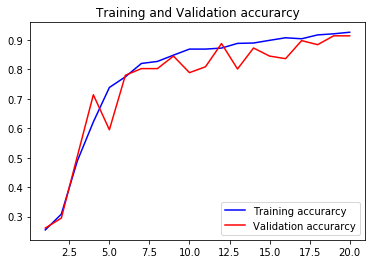

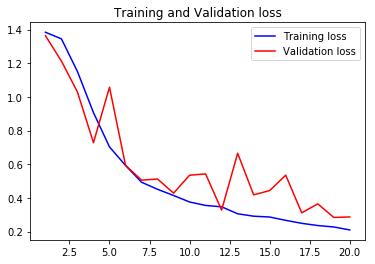

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

Model Accuracy

In [16]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
800/800 [==============================] - 1s 1ms/step
Test Accuracy: 91.375


Save model using Pickle

In [17]:
# save the model to disk
print("[INFO] Saving model...")
pickle.dump(model,open('cnn_model.pkl', 'wb'))

[INFO] Saving model...
